# Machine Learning Layer
#### Goal: Estimate the next beta

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tf as tf
from plotnine import *
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

from tensorflow import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.metrics import RootMeanSquaredError

import pickle
import joblib

## 1) Import Data:
CSV file can be found in Teams under Model/ML_for_Beta/all_matrix_data.csv

In [60]:
df = pd.read_csv('../../../../Assets/Data/all_matrix_data_v3.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)

In [61]:
df.sort_values('beta')

,week,policy_index,variant,mobility,temperature,wind,infections,beta,beta_t_minus_1,start_date_forecasting,district
29931,8,69.342857,Other,-25.142857,11.585714,10.914286,4.397959,3.206650e-22,4.185804e-01,2020-05-05,Essen
33260,12,57.440000,Other,-1.857143,15.671429,7.557143,1.061224,7.422783e-22,4.248281e-01,2020-06-02,Rhein-Sieg-Kreis
33549,16,63.390000,Other,-10.142857,20.885714,NaN,0.897959,4.943590e-21,1.880543e-02,2020-06-30,Solingen
9519,21,58.802857,Other,7.285714,19.628571,4.685714,2.357143,1.138159e-20,6.482662e-01,2020-08-04,Potsdam-Mittelmark
11600,12,57.440000,Other,6.428571,13.542857,7.914286,0.408163,4.656590e-20,1.931945e-02,2020-06-02,Neuburg-Schrobenhausen
...,...,...,...,...,...,...,...,...,...,...,...
20441,18,58.804286,Other,9.285714,13.657143,13.928571,0.938776,3.929966e+00,5.671122e-07,2020-07-14,"Schwerin, Landeshauptstadt"
10613,70,73.210000,B.1.617.2,19.000000,18.071429,9.442857,0.734694,4.097204e+00,4.810871e-07,2021-07-13,Saale-Holzland-Kreis
22773,70,73.210000,B.1.617.2,17.000000,17.714286,7.914286,0.795918,4.198941e+00,4.614146e-07,2021-07-13,Regen
17021,18,58.804286,Other,-4.714286,13.414286,NaN,2.448980,4.277427e+00,5.615672e-07,2020-07-14,"Hof, Kreis"


## 2) Visualize Data:
#### 2.1) Average Infections (training period):

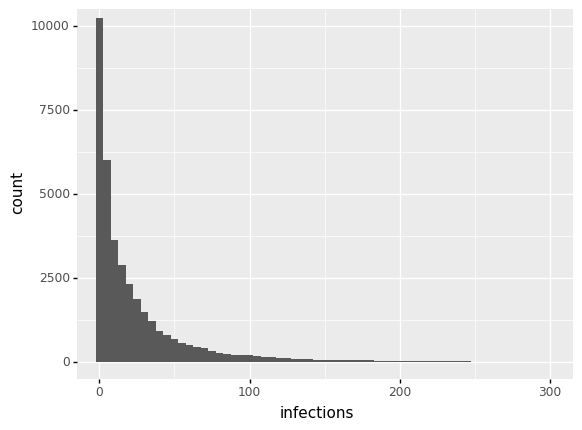

<ggplot: (380371520)>

In [62]:
ggplot(df, aes(x='infections')) + geom_histogram(binwidth=5) + coord_cartesian(xlim=(0,300),ylim=(0,10000))

#### 2.2) Fitted beta:

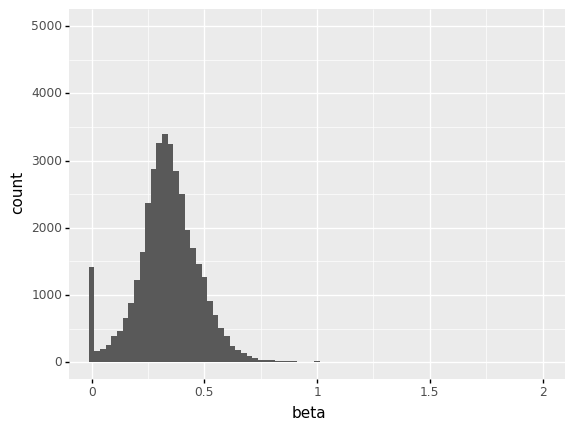

<ggplot: (376998735)>

In [63]:
ggplot(df, aes(x='beta')) + geom_histogram(binwidth=0.025) + coord_cartesian(xlim=(0,2),ylim=(0,5000))

#### 2.3) Average infections Münster

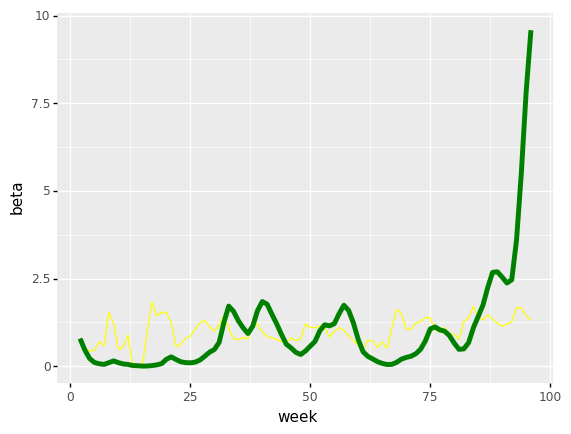

<ggplot: (376969096)>

In [64]:
district = 'Münster'
df_v2_3 = df[df['district']==district][['week','district','infections','beta']]

# Devide both columns by their mean so that they fit in one plot:
df_v2_3['infections'] = df_v2_3['infections']/df_v2_3['infections'].mean()
df_v2_3['beta'] = df_v2_3['beta']/df_v2_3['beta'].mean()

ggplot(df_v2_3) \
+ geom_line(aes(x='week', y='beta'), color='yellow')\
+ geom_line(aes(x='week', y='infections'), color='green', size=2)

#### 2.4) Policy index vs infections: (Germany)

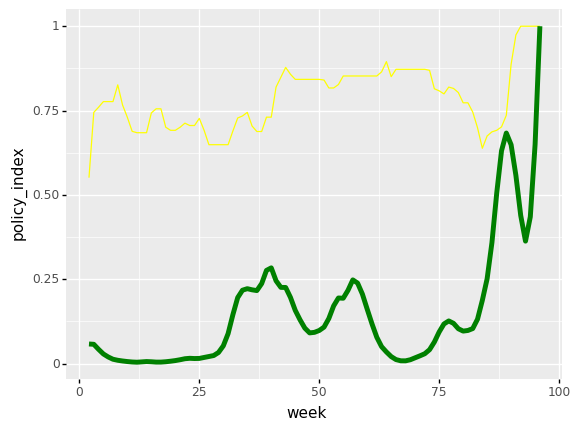

<ggplot: (380310586)>

In [65]:
df_v2_4 = df.groupby('week').sum()

# Devide both columns by their max so that they fit in one plot:
df_v2_4['infections'] = df_v2_4['infections']/df_v2_4['infections'].max()
df_v2_4['policy_index'] = df_v2_4['policy_index']/df_v2_4['policy_index'].max()

ggplot(df_v2_4.reset_index())\
+ geom_line(aes(x='week', y='policy_index'), color='yellow')\
+ geom_line(aes(x='week', y='infections'), color='green', size=2)

## 3) Feature Engineering:
#### Lagged beta: (NO LONGER NECESSARY!)

In [66]:
# Sort values by district and week before lagging:
df.sort_values(['district','week'], inplace=True)

In [67]:
# Check out correlation between current and previous weeks beta:
df['beta'].corr(df['beta_t_minus_1'] )

-0.04946080063633077

## 4) Data cleaning:
#### Identify missing values:

In [68]:
df.isnull().sum()

week                         0
policy_index                 0
variant                      0
mobility                     0
temperature                243
wind                      3827
infections                   0
beta                         0
beta_t_minus_1               0
start_date_forecasting       0
district                     0
dtype: int64

#### Fill missing values with previous column:
Forward fill: Fill down (-> if missing value in week 50 use value of week 49)

In [69]:
df_v4 = df.copy()

In [70]:
df_v4['temperature'] = df.groupby("week").transform(lambda x: x.fillna(x.mean()))['temperature']
df_v4['wind'] = df.groupby("week").transform(lambda x: x.fillna(x.mean()))['wind']

/var/folders/f9/_57rk_kx5jqbkd8vvnwckf2c0000gn/T/ipykernel_52391/1409488165.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
/var/folders/f9/_57rk_kx5jqbkd8vvnwckf2c0000gn/T/ipykernel_52391/1409488165.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.


In [71]:
df_v4

,week,policy_index,variant,mobility,temperature,wind,infections,beta,beta_t_minus_1,start_date_forecasting,district
11400,2,46.258571,Other,-29.857143,8.400000,16.342857,56.214286,0.317049,0.593156,2020-03-24,Aachen
11401,3,62.500000,Other,-41.714286,5.171429,15.042316,51.448980,0.297109,0.319949,2020-03-31,Aachen
11402,4,63.778571,Other,-34.428571,5.914286,11.157143,34.714286,0.198582,0.345324,2020-04-07,Aachen
11403,5,65.180000,Other,-29.285714,15.071429,10.571429,23.693878,0.228998,0.210615,2020-04-14,Aachen
11404,6,65.180000,Other,-32.857143,11.085714,11.071429,15.510204,0.221865,0.217996,2020-04-21,Aachen
...,...,...,...,...,...,...,...,...,...,...,...
4080,92,83.930000,B.1.617.2,-2.571429,0.428571,8.528571,287.969388,0.318062,0.356566,2021-12-14,Zwickau
4081,93,83.930000,B.1.617.2,-1.000000,4.842857,10.485714,190.122449,0.283989,0.344724,2021-12-21,Zwickau
4082,94,83.930000,B.1.617.2,-4.285714,-1.200000,10.700000,138.816327,0.341186,0.277870,2021-12-28,Zwickau
4083,95,83.930000,B.1.1.529,-15.714286,7.871429,16.885714,103.153061,0.326760,0.343163,2022-01-04,Zwickau


## 5) Outlier removal:


In [72]:
# Identify outliers:

In [73]:
df_v4[df_v4['infections'] > 20].sort_values('beta_t_minus_1', ascending=True)

,week,policy_index,variant,mobility,temperature,wind,infections,beta,beta_t_minus_1,start_date_forecasting,district
14389,46,70.710000,Other,-0.142857,2.742857,18.042857,37.357143,0.321769,0.121853,2021-01-26,Mansfeld-Südharz
25501,43,73.690000,Other,-28.857143,2.228571,11.771429,88.224490,0.448059,0.133374,2021-01-05,Regionalverband Saarbrücken
32059,46,70.710000,Other,-25.714286,3.071429,16.442857,22.653061,0.177563,0.135390,2021-01-26,Potsdam
21511,43,73.690000,Other,-23.000000,-2.485714,5.785714,22.581633,0.430256,0.144703,2021-01-05,Oberallgäu
11224,16,63.390000,Other,-14.714286,21.171429,9.714286,24.653061,0.123700,0.147413,2020-06-30,Gütersloh
...,...,...,...,...,...,...,...,...,...,...,...
3414,91,81.761429,B.1.617.2,4.000000,2.657143,15.685714,297.683673,0.410829,0.885379,2021-12-07,Börde
20074,31,54.460000,Other,21.285714,10.400000,13.555102,20.265306,0.354283,0.984769,2020-10-13,Eifelkreis Bitburg-Prüm
29260,2,46.258571,Other,-21.000000,6.371429,9.557143,24.755102,0.611139,1.050508,2020-03-24,Neustadt a.d.Waldnaab
7439,31,54.460000,Other,12.142857,9.728571,10.114286,32.959184,0.550973,1.078371,2020-10-13,Berchtesgadener Land


#### 5.1) Infection counts:
Remove weeks in which the average number of daily infections where below a threshold as for extremely low values it is really hard to forecast beta:

In [74]:
# Drop all rows in which average number of infections is below 5:
threshold = 20
df_v5_1 = df_v4[df_v4['infections'] > threshold]

#### 5.2) Beta values:

In [75]:
# Drop all rows in which the beta value is < 0.025:
threshold = 0.025
df_v5_2 = df_v5_1[df_v5_1['beta'] > threshold]

In [76]:
# correlation:
df_v5_2['beta'].corr(df_v5_2['beta_t_minus_1'] )

0.46299469609533317

## 6) Preprocessing columns:


#### 6.1) Handling categorical columns:

In [77]:
# Only use week and district as index columns:
df_v6_1 = df_v5_2.set_index(['week','district','start_date_forecasting'])

In [78]:
# One hot-encode variant columns:
df_v6_2_a = pd.get_dummies(df_v6_1['variant'])
df_v6_2_b = df_v6_1.drop(columns='variant', axis=1)

df_v6_2_c = pd.concat([df_v6_2_a,df_v6_2_b], axis=1)

In [79]:
# Drop "other" variant column to prevent dummy variable trap:
df_v6_2_d = df_v6_2_c.drop(columns='Other', axis=1)

#### 6.2) Standardizing:

In [80]:
# Standardize:
scaler_obj = StandardScaler()

# Split explanatory columns from beta:
explanatory_cols = df_v6_2_d.drop(columns=['beta'], axis=1)
beta_cols = df_v6_2_d[['beta']]

# Apply scaling:
scaled_explanatory_cols = pd.DataFrame(scaler_obj.fit_transform(explanatory_cols), index=explanatory_cols.index, columns=explanatory_cols.columns)

# Merge both together again:
df_v6_3 = pd.concat([scaled_explanatory_cols, beta_cols], axis=1)

## 7) Modeling
### 7.1) Preparation
#### 7.1.1) Split into train/val:

In [81]:
df_full = df_v6_3
df_full

,,,B.1.1.529,B.1.1.7,B.1.617.2,policy_index,mobility,temperature,wind,infections,beta_t_minus_1,beta
week,district,start_date_forecasting,,,,,,,,,,
2,Aachen,2020-03-24,-0.243616,-0.635747,-0.782084,-2.522486,-1.813104,0.444563,1.244166,-0.141755,2.134192,0.317049
3,Aachen,2020-03-31,-0.243616,-0.635747,-0.782084,-0.675429,-2.643120,-0.210696,0.906138,-0.179311,-0.684498,0.297109
4,Aachen,2020-04-07,-0.243616,-0.635747,-0.782084,-0.530024,-2.133110,-0.059928,-0.103671,-0.311199,-0.422703,0.198582
5,Aachen,2020-04-14,-0.243616,-0.635747,-0.782084,-0.370647,-1.773103,1.798572,-0.255906,-0.398051,-1.812507,0.228998
29,Aachen,2020-09-29,-0.243616,-0.635747,-0.782084,-1.589778,0.366940,1.613012,0.806026,-0.358887,-0.438264,0.416920
...,...,...,...,...,...,...,...,...,...,...,...,...
92,Zwickau,2021-12-14,-0.243616,-0.635747,1.278635,1.761697,0.096934,-1.173288,-0.786872,1.684726,-0.306718,0.318062
93,Zwickau,2021-12-21,-0.243616,-0.635747,1.278635,1.761697,0.206936,-0.277381,-0.278184,0.913586,-0.428888,0.283989
94,Zwickau,2021-12-28,-0.243616,-0.635747,1.278635,1.761697,-0.023068,-1.503817,-0.222489,0.509238,-1.118625,0.341186


In [118]:
# Sample 1500 row out of last weeks available for training:
sample_size = 1000
max_week = max(df_full.index.get_level_values('week'))
last_weeks_idx = max_week-3

random_indices = df_full[df_full.index.get_level_values('week') >= last_weeks_idx].sample(sample_size).index

In [120]:
df_test = df_full.loc[df_full.index.isin(random_indices)]
df_modeling = df_full.loc[~df_full.index.isin(random_indices)]

#### 7.1.2) Split into train, val and test:

In [121]:
SEED = 420

In [122]:
X_full_modeling = df_modeling.drop(columns=['beta'], axis=1)
y_full_modeling = df_modeling['beta']

X_test = df_test.drop(columns=['beta'], axis=1)
y_test = df_test['beta']

In [123]:
# Train and Val:
X_train, X_val, y_train, y_val = train_test_split(X_full_modeling, y_full_modeling, shuffle=True, train_size=0.75, random_state=SEED)

### 7.2 Models
#### 7.2.1) Baseline Approach: Choosing previous beta

In [124]:
# Baseline approach would be to use the beta from the previous week for the next week:
## Therefore we have to compare how well this works, compared to our ML approach:

# As the values are standardized we have to reverse standardize them first:
y_pred_baseline_val = pd.DataFrame(scaler_obj.inverse_transform(X_val), index=X_val.index, columns=X_val.columns)['beta_t_minus_1']

In [125]:
# Correlation of this approach:
y_pred_baseline_val.corr(y_val)

0.48144009183478276

In [126]:
pd.DataFrame({'y_val':y_val, 'y_pred_baseline':y_pred_baseline_val})

,,,y_val,y_pred_baseline
week,district,start_date_forecasting,,
93,Haßberge,2021-12-21,0.324538,0.301385
79,Unna,2021-09-14,0.312752,0.310760
95,Rhein-Kreis Neuss,2022-01-04,0.564513,0.446533
62,Reutlingen,2021-05-18,0.240871,0.233417
34,Aachen,2020-11-03,0.307538,0.356226
...,...,...,...,...
85,Landkreis Rostock,2021-10-26,0.482966,0.425951
92,"Schweinfurt, Stadt",2021-12-14,0.256481,0.265893
40,"Oldenburg, Kreis",2020-12-15,0.377889,0.376724


In [127]:
# Compute RMSE of baseline approach:
rmse_baseline =  mean_squared_error(y_val, y_pred_baseline_val, squared=False)
print(f'Baseline RMSE is: {rmse_baseline}')

Baseline RMSE is: 0.0964195183310291


#### 7.2.2) Multivariate Linear Regression

In [128]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

y_pred_linreg = regr.predict(X_val)
rmse_linreg = mean_squared_error(y_val, y_pred_linreg, squared=False)

In [129]:
print(f'RMSE of {regr} is: {rmse_linreg}. This is an improvement compared to the baseline approach of: {-(rmse_linreg / rmse_baseline -1)*100} %')

RMSE of LinearRegression() is: 0.06402672044983249. This is an improvement compared to the baseline approach of: 33.59568523251186 %


#### 7.2.3) Ridge Regression:

In [130]:
ridge_reg = linear_model.Ridge()
ridge_reg.fit(X_train, y_train)

y_pred_ridge_reg = ridge_reg.predict(X_val)
rmse_ridge_reg = mean_squared_error(y_val, y_pred_ridge_reg, squared=False)

In [131]:
print(f'RMSE of {ridge_reg} is: {rmse_ridge_reg}. This is an improvement compared to the baseline approach of: {-(rmse_ridge_reg / rmse_baseline -1)*100} %')

RMSE of Ridge() is: 0.06402687452221954. This is an improvement compared to the baseline approach of: 33.59552543873803 %


#### 7.2.4) Random Forest Regressor:

In [132]:
rfg_model = RandomForestRegressor()
rfg_model.fit(X_train, y_train)

y_pred_random_forest = rfg_model.predict(X_val)
rmse_random_forest = mean_squared_error(y_val, y_pred_random_forest, squared=False)

In [133]:
print(f'RMSE of {rfg_model} is: {rmse_random_forest}. This is an improvement compared to the baseline approach of: {-(rmse_random_forest / rmse_baseline -1)*100} %')

RMSE of RandomForestRegressor() is: 0.053878432465976005. This is an improvement compared to the baseline approach of: 44.12082387613713 %


#### 7.2.5) Support Vector Machines

In [134]:
svm = SVR()
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_val)
rmse_svm = mean_squared_error(y_val, y_pred_svm, squared=False)

In [135]:
print(f'RMSE of {svm} is: {rmse_svm}. This is an improvement compared to the baseline approach of: {-(rmse_svm / rmse_baseline -1)*100} %')

RMSE of SVR() is: 0.060587256632197176. This is an improvement compared to the baseline approach of: 37.16287150057316 %


#### 7.2.6) XGBoost

In [136]:
xgb_model = xgb.XGBRegressor(verbosity=0)
xgb_model.name = 'XGBoostRegressor'
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_val)
rmse_xgb = mean_squared_error(y_val, y_pred_xgb, squared=False)

In [137]:
print(f'\n RMSE of {xgb_model.name} is: {rmse_xgb}. This is an improvement compared to the baseline approach of: {-(rmse_xgb / rmse_baseline -1)*100} %')


 RMSE of XGBoostRegressor is: 0.055410995349212976. This is an improvement compared to the baseline approach of: 42.531350178523994 %


In [138]:
pd.DataFrame({'beta_opt':y_val, 'last_beta':y_pred_baseline_val, 'last_beta_standardized':X_val['beta_t_minus_1'], 'xgb_pred':y_pred_xgb}).sort_values('start_date_forecasting', ascending=False)

beta_opt  last_beta  \
week district               start_date_forecasting                        
96   Osterholz              2022-01-11              0.409358   0.494610   
     Heilbronn, Stadt       2022-01-11              0.695767   0.529196   
     Schwarzwald-Baar-Kreis 2022-01-11              0.571342   0.448548   
     Greiz                  2022-01-11              0.181197   0.452456   
     Nordhausen             2022-01-11              0.305014   0.381039   
...                                                      ...        ...   
2    Hamburg                2020-03-24              0.297351   0.566038   
     Borken                 2020-03-24              0.263655   0.536370   
     Steinfurt              2020-03-24              0.331492   0.657779   
     Rhein-Erft-Kreis       2020-03-24              0.393936   0.647492   
     Hohenlohekreis         2020-03-24              0.256551   0.552307   

                                                    last_beta_standardized  \
week district               start_date_forecasting                           
96   Osterholz              2022-01-11                            1.117491   
     Heilbronn, Stadt       2022-01-11                            1.474320   
     Schwarzwald-Baar-Kreis 2022-01-11                            0.642268   
     Greiz                  2022-01-11                            0.682583   
     Nordhausen             2022-01-11                           -0.054226   
...                                                                    ...   
2    Hamburg                2020-03-24                            1.854418   
     Borken                 2020-03-24                            1.548333   
     Steinfurt              2020-03-24                            2.800920   
     Rhein-Erft-Kreis       2020-03-24                            2.694782   
     Hohenlohekreis         2020-03-24                            1.712758   

                                                    xgb_pred  
week district               start_date_forecasting            
96   Osterholz              2022-01-11              0.518341  
     Heilbronn, Stadt       2022-01-11              0.555339  
     Schwarzwald-Baar-Kreis 2022-01-11              0.542406  
     Greiz                  2022-01-11              0.397328  
     Nordhausen             2022-01-11              0.390119  
...                                                      ...  
2    Hamburg                2020-03-24              0.337044  
     Borken                 2020-03-24              0.411268  
     Steinfurt              2020-03-24              0.414967  
     Rhein-Erft-Kreis       2020-03-24              0.448824  
     Hohenlohekreis         2020-03-24              0.444424  

[3249 rows x 4 columns]

#### 7.2.7) Neural Network

In [139]:
ann_model = Sequential([
    Dense(24, input_dim=len(X_train.columns), activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])


# compile model:
ann_model.compile(
    loss = 'mse',
    optimizer = 'adam',
    metrics=[RootMeanSquaredError(name='rmse')]
)

In [ ]:
history = ann_model.fit(X_train,
                        y_train,
                        epochs=20,
                        # class_weight=class_weight,
                        validation_data=(X_val, y_val),
                        )

Epoch 1/20
305/305 [==============================] - 1s 1ms/step - loss: 0.0644 - rmse: 0.2538 - val_loss: 0.0098 - val_rmse: 0.0992
Epoch 2/20
305/305 [==============================] - 0s 948us/step - loss: 0.0162 - rmse: 0.1274 - val_loss: 0.0060 - val_rmse: 0.0772
Epoch 3/20
305/305 [==============================] - 0s 962us/step - loss: 0.0078 - rmse: 0.0883 - val_loss: 0.0049 - val_rmse: 0.0701
Epoch 4/20
305/305 [==============================] - 0s 979us/step - loss: 0.0061 - rmse: 0.0778 - val_loss: 0.0047 - val_rmse: 0.0688
Epoch 5/20
305/305 [==============================] - 0s 939us/step - loss: 0.0057 - rmse: 0.0757 - val_loss: 0.0047 - val_rmse: 0.0686
Epoch 6/20
305/305 [==============================] - 0s 940us/step - loss: 0.0054 - rmse: 0.0734 - val_loss: 0.0045 - val_rmse: 0.0674
Epoch 7/20
208/305 [===================>..........] - ETA: 0s - loss: 0.0050 - rmse: 0.0706

In [ ]:
y_pred_ann = ann_model.predict(X_val)
rmse_ann = mean_squared_error(y_val, y_pred_ann, squared=False)

In [ ]:
print(f'RMSE of {ann_model} is: {rmse_ann}. This is an improvement compared to the baseline approach of: {-(rmse_ann / rmse_baseline -1)*100} %')

## 8) Model Evaluation:

### Metric Computation:

#### Baseline:

In [ ]:
y_pred_baseline_test = pd.DataFrame(scaler_obj.inverse_transform(X_test), index=X_test.index, columns=X_test.columns)['beta_t_minus_1']
rmse_baseline_test = mean_squared_error(y_pred_baseline_test, y_test, squared=False)
print(f'RMSE of baseline approach is: {rmse_baseline_test}')

#### Random Forest:

In [ ]:
# Apply optimal model to testset:
y_pred_test_rf = rfg_model.predict(X_test)

rmse_rf_test = mean_squared_error(y_pred_test_rf, y_test, squared=False)
print(f'RMSE of {rfg_model} is: {rmse_rf_test}. This is an improvement compared to the baseline approach of: {-(rmse_rf_test / rmse_baseline_test -1)*100}%')

#### XGB Boost:

In [ ]:
# Apply optimal model to testset:
y_pred_test_xgb = xgb_model.predict(X_test)

rmse_xgb_test = mean_squared_error(y_pred_test_xgb, y_test, squared=False)
print(f'RMSE of {xgb_model.name} is: {rmse_xgb_test}. This is an improvement compared to the baseline approach of: {-(rmse_xgb_test / rmse_baseline_test -1)*100}%')

### Model comparison:

In [ ]:
rmses_dict = {
    'LinReg': rmse_linreg,
    'Ridge_Reg': rmse_ridge_reg,
    'Random_Forest': rmse_random_forest,
    'SVM': rmse_svm,
    'XGB': rmse_xgb,
    'ANN':rmse_ann,
    'Baseline': rmse_baseline,
}

rmses_rel_improvement = {k:(-(v/rmse_baseline-1)*100) for (k,v) in rmses_dict.items()}
rmses_rel_improvement

plt.bar(x=rmses_rel_improvement.keys(),height=rmses_rel_improvement.values())
plt.title("Relative Improvement to Using the Last Beta:")
plt.xlabel(xlabel='Machine Learning Regression Approaches')
plt.ylabel(ylabel='Relative Improvement to RMSE %')
plt.show()

### Feature Importance:

In [ ]:
feature_important = xgb_model.get_booster().get_score(importance_type='gain')

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (12,10)) ## plot top 40 features

In [ ]:
perm_importance = permutation_importance(xgb_model, X_test, y_test)

In [ ]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

### Residual analysis:

In [ ]:
residuals_df = pd.DataFrame({
    'beta_opt':y_test, 'last_beta_pred':y_pred_baseline_test, 'xgb_pred':y_pred_test_xgb,
    'residual_last_beta': y_pred_baseline_test-y_test,
    'residual_xgb_pred': y_pred_test_xgb-y_test,
})
residuals_df

In [ ]:
## Plot residuals:
# Last Beta
ggplot(residuals_df, aes(x='residual_last_beta')) + geom_histogram(binwidth=0.01) + coord_cartesian(xlim=(-0.5,0.5),ylim=(0,100))

In [ ]:
# XGB Beta
ggplot(residuals_df, aes(x='residual_xgb_pred')) + geom_histogram(binwidth=0.01) + coord_cartesian(xlim=(-0.5,0.5),ylim=(0,100))

## 9) Export Best Model:

In [ ]:
path = '../../../../Assets/MachineLearningLayer/Models/'
best_model = xgb_model

# ML Model:
filename = 'xgb_model_lukas.pkl'
combined_path = path+filename
joblib.dump(best_model, open(combined_path, 'wb'))

# Standardizer:
filename = 'standardizer_model.pkl'
combined_path = path+filename
joblib.dump(scaler_obj, open(path+filename, 'wb'))

print('succesfully exported')